# **Hand Sign Detection**

### *Importing Libraries*

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks,
                              mp_holistic.FACE_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks,
                              mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks,
                              mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(
        image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_landmarks(image, results):

    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(
                                  color=(80, 110, 10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(
                                  color=(80, 256, 121), thickness=1, circle_radius=1)
                              )

    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(
                                  color=(80, 22, 10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(
                                  color=(80, 44, 121), thickness=2, circle_radius=2)
                              )

    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(
                                  color=(121, 22, 76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(
                                  color=(121, 44, 250), thickness=2, circle_radius=2)
                              )

    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(
                                  color=(245, 117, 66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(
                                  color=(245, 66, 230), thickness=2, circle_radius=2)
                              )

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten(
    ) if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten(
    ) if results.face_landmarks else np.zeros(1404)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten(
    ) if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten(
    ) if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [7]:
DATA_PATH = os.path.join('MP_DATA')

actions = np.array(['Hello', 'Dab', 'Heart', 'Super',
                   'Namaste', 'Okay'])

no_sequences = 50
sequence_length = 8

In [8]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [9]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_styled_landmarks(image, results)
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video number{}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number{}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(
                    DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                cv2.imshow('OpenCV Feed', image)
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()

In [10]:
cap.release()
cv2.destroyAllWindows()

In [11]:
from keras.utils import to_categorical

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
label_map = {label: num for num, label in enumerate(actions)}

In [14]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(
                sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [15]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [16]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**LSTM Neural Network**

In [88]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard

In [89]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [90]:
model = Sequential()
model.add(LSTM(64, return_sequences=True,
          activation='relu', input_shape=(8, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [91]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[
              'categorical_accuracy'])

In [92]:
history = model.fit(X_train, y_train, epochs=300, callbacks=[tb_callback])

Epoch 1/300
8/8 [==============================] - 3s 22ms/step - loss: 1.7961 - categorical_accuracy: 0.1167
Epoch 2/300
8/8 [==============================] - 0s 22ms/step - loss: 1.7779 - categorical_accuracy: 0.1542
Epoch 3/300
8/8 [==============================] - 0s 22ms/step - loss: 1.6304 - categorical_accuracy: 0.2958
Epoch 4/300
8/8 [==============================] - 0s 22ms/step - loss: 1.5682 - categorical_accuracy: 0.2792
Epoch 5/300
8/8 [==============================] - 0s 23ms/step - loss: 1.3509 - categorical_accuracy: 0.3625
Epoch 6/300
8/8 [==============================] - 0s 22ms/step - loss: 1.2881 - categorical_accuracy: 0.4000
Epoch 7/300
8/8 [==============================] - 0s 22ms/step - loss: 1.1419 - categorical_accuracy: 0.4250
Epoch 8/300
8/8 [==============================] - 0s 23ms/step - loss: 1.2672 - categorical_accuracy: 0.3583
Epoch 9/300
8/8 [==============================] - 0s 25ms/step - loss: 1.2766 - categorical_accuracy: 0.4792
Epoch 10/3

In [93]:
from keras.utils import plot_model

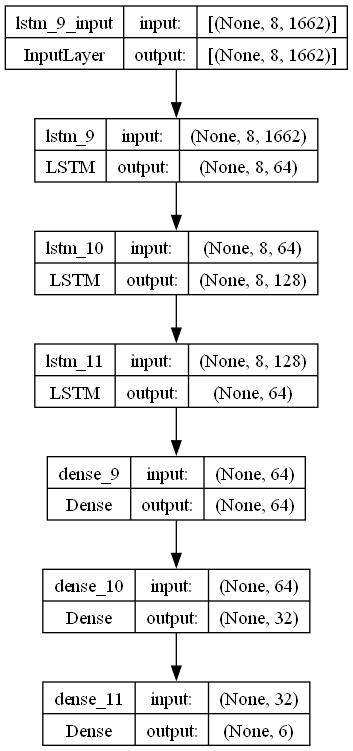

In [94]:
plot_model(model, to_file='radomtest.png', show_shapes=True)

**Make Predictions**

In [95]:
res = model.predict(X_test)

2/2 [==============================] - 0s 8ms/step


In [96]:
actions[np.argmax(res[4])]

'Dab'

In [97]:
actions[np.argmax(y_test[4])]

'Dab'

**Save Model**

In [98]:
model.save('MediapipeModel.h5')

c:\Users\21bcm\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [99]:
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix

In [100]:
yhat = model.predict(X_test)

2/2 [==============================] - 0s 8ms/step


In [101]:
yactual = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [102]:
multilabel_confusion_matrix(yactual, yhat)

array([[[47,  0],
        [ 0, 13]],

       [[52,  0],
        [ 0,  8]],

       [[50,  0],
        [ 0, 10]],

       [[50,  2],
        [ 0,  8]],

       [[51,  0],
        [ 2,  7]],

       [[48,  0],
        [ 0, 12]]], dtype=int64)

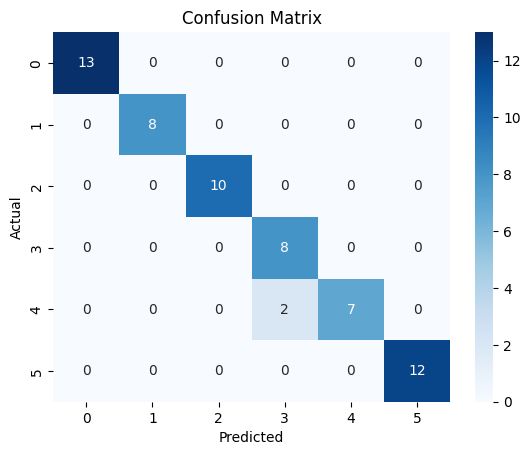

In [103]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(yactual, yhat)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

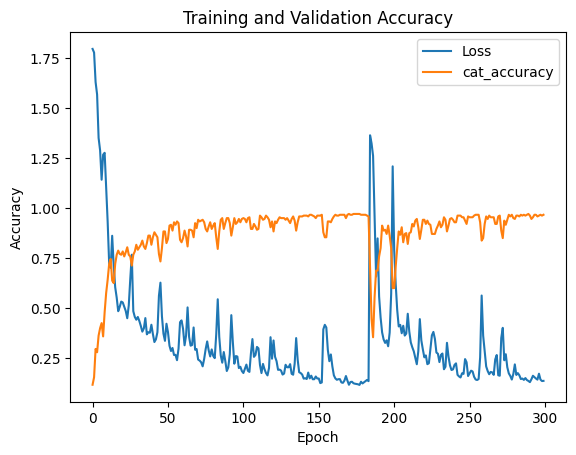

In [104]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['categorical_accuracy'], label='cat_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [107]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming yactual and yhat are the true labels and predicted labels or scores

# Precision
# Use 'micro', 'macro', or 'weighted'
precision = precision_score(yactual, yhat, average='weighted')
print("Precision:", precision)

# Recall
# Use 'micro', 'macro', or 'weighted'
recall = recall_score(yactual, yhat, average='weighted')
print("Recall:", recall)

# F1 score
# Use 'micro', 'macro', or 'weighted'
f1 = f1_score(yactual, yhat, average='weighted')
print("F1 score:", f1)

Precision: 0.9733333333333333
Recall: 0.9666666666666667
F1 score: 0.9664351851851852


In [105]:
accuracy_score(yactual, yhat)

0.9666666666666667

In [66]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245),
          (255, 0, 0), (0, 255, 0), (255, 165, 0)]


def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40),
                      (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    return output_frame

In [38]:
from scipy import stats

**Test in Real time**

In [ ]:
sequence = []
sentence = []
threshold = 0.4

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
        print(results)

        draw_styled_landmarks(image, results)

     
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[:-30]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])

            # Visulaisation prediction logic
        if res[np.argmax(res)] > threshold:
            if len(sentence) > 0:
                if actions[np.argmax(res)] != sentence[-1]:
                    sentence.append(actions[np.argmax(res)])
            else:
                sentence.append(actions[np.argmax(res)])
        if len(sentence) > 5:
            sentence = sentence[-5:]

        # Visualise Probability
        image = prob_viz(res, actions, image, colors)
        # cv2.rectangle(image,(0,0),(640,40),(245,117,16),-1)
        cv2.putText(image, ''.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from keras.models import load_model

model = load_model(
    "D:/College Stuff/Trimester 9/Deep Learning/Programs/Assignment/Github/MediapipeModel.h5")

threshold = 0.4
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        image, results = mediapipe_detection(frame, holistic)
        print(results)

        draw_styled_landmarks(image, results)

        # Prediction logic code
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]  # Maintain the last 30 frames

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])

            # Visualization prediction logic
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])
            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Visualize Probability
            image = prob_viz(res, actions, image, colors)
            cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ''.join(sentence), (3, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
sequence = []
sentence = []
threshold = 0.4
cap = cv2.VideoCapture(0)


with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
        print(results)

        draw_styled_landmarks(image, results)

        keypoints = extract_keypoints(results)
        sequence.insert(0, keypoints)
        sequence = sequence[:-30]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])

            # Visulaisation prediction logic
        if res[np.argmax(res)] > threshold:
            if len(sentence) > 0:
                if actions[np.argmax(res)] != sentence[-1]:
                    sentence.append(actions[np.argmax(res)])
            else:
                sentence.append(actions[np.argmax(res)])
        if len(sentence) > 5:
            sentence = sentence[-5:]

        # Visualise Probability
        # image = prob_viz(res, actions, image, actions)
        image = prob_viz(res, actions, image, colors)
        # cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        # cv2.rectangle(image, (0, 640), (100, 640), (255, 255, 255), 0)

        cv2.putText(image, ''.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [44]:
sequence = []
sentence = []
predictions = []
threshold = 0.1

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]

            print(res)

            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))

        # 3. Viz logic
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:

                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)

            cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti